## Analysis of Ejaz 2015, Nat Neuro, 31-flexion chord data
Ali Ghavampour 2024
alighavam79@gmail.com
aghavamp@uwo.ca

From Naveed's data I made two combined dataframes with `parse_CPD_data.m` code. Take a look there and also paper methods for the details of the regressors and experiment. The data I will be using here are: `cpd_glm_betas.mat` and `cpd_glm_info.tsv`.

In [ ]:
! pip install statsmodels --upgrade

In [9]:
import numpy as np
import PcmPy as pcm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import os
from scipy import stats

# Load the data
mat = scipy.io.loadmat(os.path.join('analysis','cpd_reg_data_1.mat'))
glm_betas = mat
# glm_betas = glm_betas[0,0]
# glm_betas['beta'].shape
# # checking the imported structure fields:
# print(glm_betas.dtype.names)

# hem         = {'lh','rh'};
# hemName     = {'LeftHem','RightHem'};
# regname     = {'S1','M1','PMd','PMv','SMA','V12','SPLa','SPLp'};

glm_info = scipy.io.loadmat(os.path.join('analysis','cpd_SPM_info_1.mat'))
glm_info['run'][249:496] = glm_info['run'][249:496] + 8
glm_info['run'][497:744] = glm_info['run'][497:744] + 16

## Estimating reliability of the data

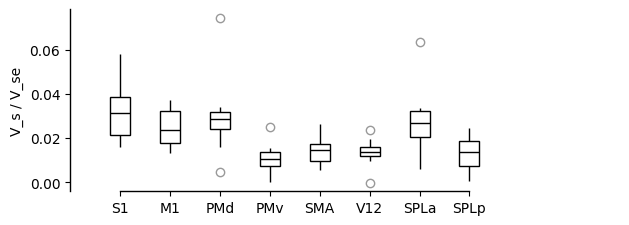

In [10]:
from utils import dataset as ds
import importlib
importlib.reload(ds)

region_names = ['S1','M1','PMd','PMv','SMA','V12','SPLa','SPLp']
region = [1,2,3,4,5,6,7,8]

snr = []
for reg in region:
    reg_idx = (glm_betas['regNum']==reg).flatten()
    beta = glm_betas['beta'][reg_idx] / np.sqrt(glm_betas['ResMs'][reg_idx])
    beta = beta.T
    subj_vec = glm_betas['sn'][reg_idx].flatten()

    partition_vec = glm_info['run'][(glm_info['sn']==1).flatten()].flatten()
    cond_vec = glm_info['chord'][(glm_info['sn']==1).flatten()].flatten()
    
    v_s, v_se = ds.within_subj_var(data = beta, partition_vec=partition_vec, cond_vec=cond_vec, subj_vec=subj_vec, subtract_mean=True)
    snr.extend(v_s / v_se)

region_indicator = np.repeat(np.array(region),np.unique(subj_vec).shape[0])
snr = np.array(snr)

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(18*cm, 6*cm))

# Define custom properties for the box plot
boxprops = dict(edgecolor='#000000', linewidth=1)
whiskerprops = dict(color='#000000', linewidth=1)
capprops = dict(visible=False)  # Remove the caps
medianprops = dict(color='#000000', linewidth=1)

sns.boxplot(x=region_indicator, y=snr, dodge=True, width=0.4, color='#ffffff',
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

ax.set_xlim([-1, 10])
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(region_names)
ax.set_ylabel('V_s / V_se')

# Make it pretty:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.spines["left"].set_bounds(ax.get_ylim()[0], ax.get_ylim()[-1])
ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

plt.savefig(os.path.join('figures','cpd_snr.pdf'), format='pdf', bbox_inches='tight')

plt.show()

## Covariance in different regions

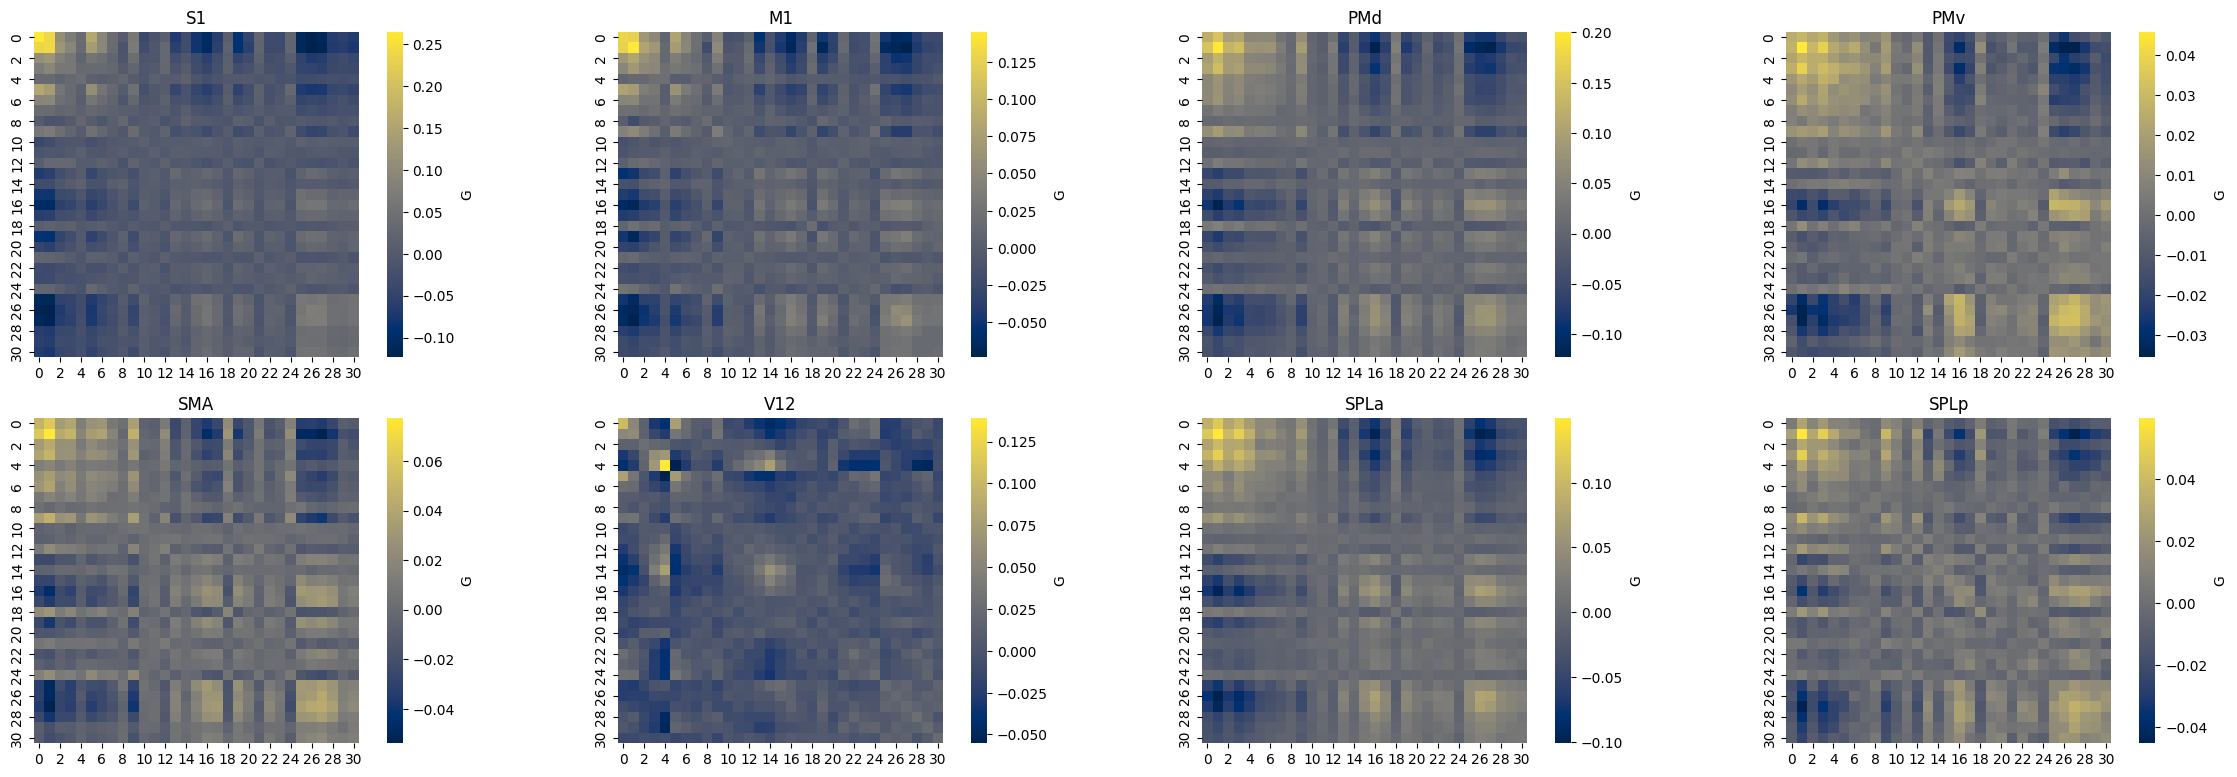

In [5]:
beta = glm_betas['beta'] / np.sqrt(glm_betas['ResMs'])

# region info:
region_names = ['S1','M1','PMd','PMv','SMA','V12','SPLa','SPLp']
region = [1,2,3,4,5,6,7,8]

sn = np.unique(glm_info['sn'])
# Estimate and plot the second moment matrices
N=sn.shape[0]
G_hat = np.zeros((N,len(region),31,31))
for reg in region:
    for s in sn:
        voxel_idx = ((glm_betas['regNum']==reg) & (glm_betas['sn']==s)).flatten()
        Y = beta[voxel_idx,:].T

        partition_vec = glm_info['run'][(glm_info['sn']==s).flatten()].flatten()
        cond_vec = glm_info['chord'][(glm_info['sn']==s).flatten()].flatten()
        
        G_hat[s-1,reg-1,:,:],_ = pcm.est_G_crossval(Y,
                                                    cond_vec,
                                                    partition_vec,
                                                    X=pcm.matrix.indicator(partition_vec))

# average G across subjects:
G_avg = G_hat.mean(axis=0)

# plot the second moment matrices:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(60*cm, 20*cm))

cm = 1/2.54  # centimeters in inches
for i, ax in enumerate(axes.flat):
    sns.heatmap(G_avg[i,:,:], cmap='cividis', square=True, cbar_kws={'label': 'G'}, ax=ax)
    ax.set_title(f'{region_names[i]}')

plt.tight_layout()
plt.savefig(os.path.join('figures','cpd_avgG.pdf'), format='pdf', bbox_inches='tight')
plt.show()
